https://stepik.org/lesson/501479/step/1?unit=493164  
https://drive.google.com/drive/folders/15UoRIwvCOZ-6c624m5NTDfbFizOs-C0N  
https://www.kaggle.com/c/advanced-dls-spring-2021/  

In [174]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

target_col = 'Churn'

In [284]:
# kaggle 0.85302

def prepare_data(data):
    data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,25,33,43,53,62,70,72,100]).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,125,5)).astype(str)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'))
train_data = prepare_data(pd.read_csv('./train.csv'))

num_cols_ = []
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG']
num_tran, cat_tran = StandardScaler(), OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer([('cat', cat_tran, cat_cols_), ('num', num_tran, num_cols_)])
classifier = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model = Pipeline([('pre', preprocessor), ('clf', classifier)])
s = cross_val_score(model, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=StratifiedKFold(10))
print(f'{s.mean():.4f}, {s.std():.6f}, {s}')

model.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

0.8486, 0.012765, [0.85602287 0.86915698 0.8563731  0.82599405 0.84755667 0.83037904
 0.85118915 0.86200297 0.84141222 0.84555492]


In [281]:
grid = {'clf__C':[0.4,0.45,0.5,0.55,0.6], 'clf__penalty':['l1','l2']}
cv = GridSearchCV(model, grid, scoring='roc_auc', cv=StratifiedKFold(10))
cv.fit(train_data[cat_cols_], train_data[target_col])
params = cv.best_estimator_.get_params()
params['clf__C'], params['clf__penalty']

(0.5, 'l1')

In [183]:
# kaggle 0.85283

def prepare_data(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
    data['TotalSpent'] = data['TotalSpent'].fillna(0)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'))
train_data = prepare_data(pd.read_csv('./train.csv'))

num_cols_ = num_cols
cat_cols_ = cat_cols
catboost = CatBoostClassifier(learning_rate=0.16, num_trees=63)
catboost.set_params(cat_features=cat_cols_, silent=True)
s = cross_val_score(catboost, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=10)
print(f'{s.mean():.4f}, {s.var():.6f}, {s}')

catboost.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = catboost.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

0.8480, 0.000122, [0.85309906 0.86536617 0.85293571 0.83297101 0.85815682 0.82840951
 0.84746377 0.85682832 0.84400141 0.84039504]


In [48]:
grid = {'learning_rate':[0.155,0.16,0.165], 'num_trees':[60,61,62,63,64]}
catboost = CatBoostClassifier().set_params(cat_features=cat_cols, silent=True)
cv = GridSearchCV(catboost, grid, scoring='roc_auc', cv=10)
cv.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
params = cv.best_estimator_.get_params()
params['learning_rate'], params['num_trees']

(0.16, 63)

ClientPeriod     TotalSpent    0.826658
MonthlySpending  TotalSpent    0.652014
dtype: float64


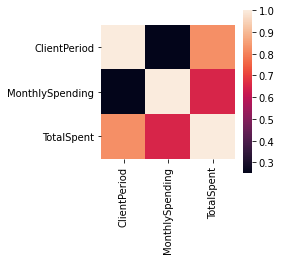

In [329]:
def prepare_data(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
    data['TotalSpent'] = data['TotalSpent'].fillna(0)
    return data

train_data = prepare_data(pd.read_csv('./train.csv'))
test_data = prepare_data(pd.read_csv('./test.csv'))

corr = train_data[num_cols].corr(method='pearson').abs()
np.fill_diagonal(corr.values, np.nan)
corr = corr.unstack().sort_values(ascending=False).drop_duplicates()
print(corr[corr > 0.6])

plt.figure(figsize=(3,3))
sns.heatmap(train_data[num_cols].corr(method='pearson').abs(), square=True);

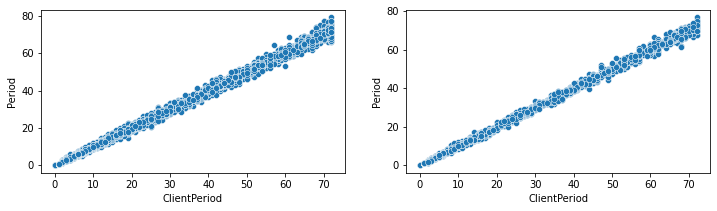

In [323]:
def prepare_data(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
    data['TotalSpent'] = data['TotalSpent'].fillna(0)
    data['Period'] = data['TotalSpent'] / data['MonthlySpending']
    return data

train_data = prepare_data(pd.read_csv('./train.csv'))
test_data = prepare_data(pd.read_csv('./test.csv'))
fig, axes = plt.subplots(1,2,figsize=(12,3))
sns.scatterplot(x='ClientPeriod', y='Period', data=train_data, ax=axes[0])
sns.scatterplot(x='ClientPeriod', y='Period', data=test_data, ax=axes[1]);

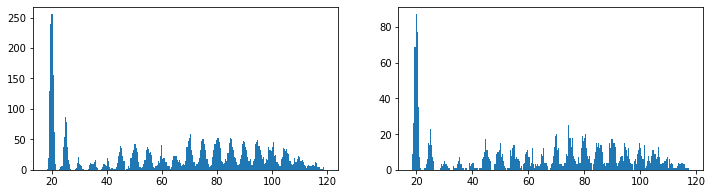

In [310]:
# multimodal normal distribution
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
fig, axes = plt.subplots(1,2,figsize=(12,3))
axes[0].hist(train_data['MonthlySpending'], bins=250)
axes[1].hist(test_data['MonthlySpending'], bins=250);

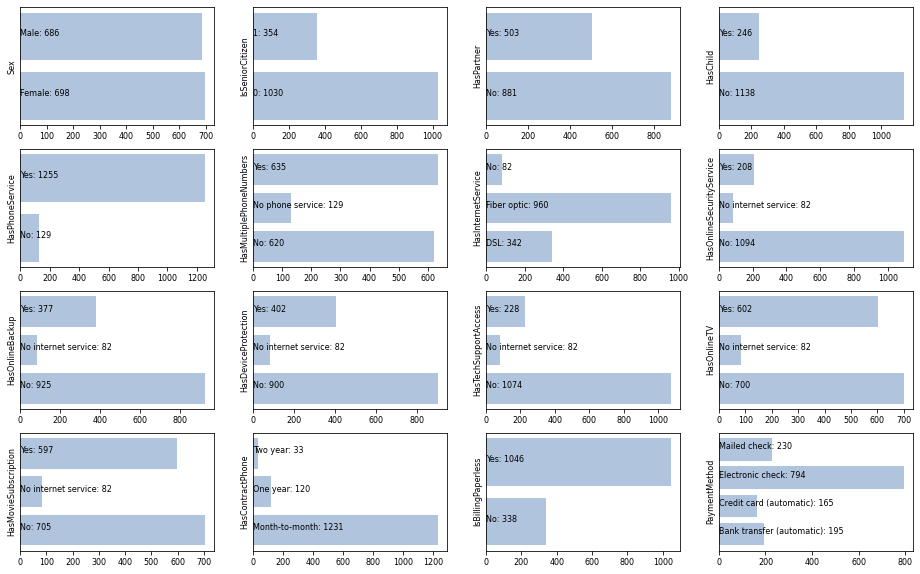

In [336]:
train_data = pd.read_csv('./train.csv')
fig, axes = plt.subplots(4, 4, figsize=(16,10))
for c, ax in zip(cat_cols, axes.flat):
    cnt = train_data.groupby(c)['Churn'].sum()
    ax.barh(cnt.index, cnt.values, color='lightsteelblue')
    ax.tick_params(axis='x', labelsize=8)
    ax.set_ylabel(c, fontsize=8)
    ax.set_yticks([])
    z = zip(range(len(cnt)), cnt.index, cnt.values)
    for i, k, v in z: ax.text(0, i, f'{k}: {v}', fontsize=8)

In [325]:
def prepare_data(data):
    data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,25,33,43,53,62,70,72,100]).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,125,5)).astype(str)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'))
train_data = prepare_data(pd.read_csv('./train.csv'))

num_cols_ = []
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG']
num_tran, cat_tran = StandardScaler(), OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer([('cat', cat_tran, cat_cols_), ('num', num_tran, num_cols_)])
classifier = KNeighborsClassifier(n_neighbors=90, leaf_size=1, p=1)
model = Pipeline([('pre', preprocessor), ('clf', classifier)])
s = cross_val_score(model, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=StratifiedKFold(10))
print(f'{s.mean():.4f}, {s.std():.6f}, {s}')

model.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

0.8281, 0.017077, [0.82629589 0.8469655  0.82209216 0.80027871 0.83951133 0.80282423
 0.83045336 0.85909513 0.82828133 0.82470271]


In [294]:
grid = {'clf__n_neighbors':range(50,100,5), 'clf__leaf_size':range(1,50,5), 'clf__p':[1,2]}
cv = GridSearchCV(model, grid, scoring='roc_auc', cv=StratifiedKFold(10))
cv.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
params = cv.best_estimator_.get_params()
params['clf__n_neighbors'], params['clf__leaf_size'], params['clf__p']

(90, 1)

In [279]:
# data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
# data['TotalSpent'] = data['TotalSpent'].fillna(0)

In [240]:
data = pd.read_csv('./test.csv')
data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,24,33,43,53,62,70,72,100]).astype(str)
# data.groupby('ClientPeriodG')['Churn'].size()
# data[data['ClientPeriod'] == 0]['ClientPeriodG']
# data.groupby('ClientPeriodG')['Churn'].mean()
# cats, bins = pd.qcut(data['ClientPeriod'], 11, retbins=True)

<AxesSubplot:>

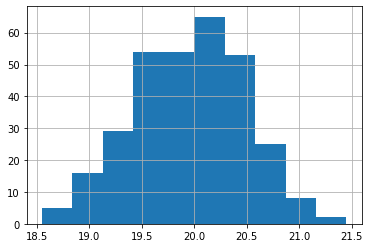

In [229]:
data[data['MonthlySpending'].between(17.5,22.5)]['MonthlySpending'].hist()

In [221]:
data[data['MonthlySpending'].between(22.5, 27.5)]['Churn'].mean()

0.10778443113772455

In [9]:
data = pd.read_csv('./train.csv')
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')

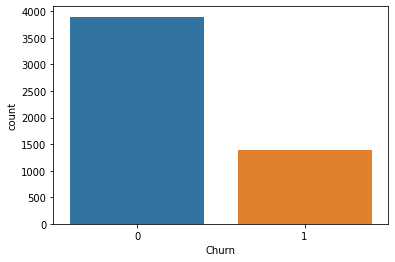

In [192]:
sns.countplot(x=target_col, data=data);

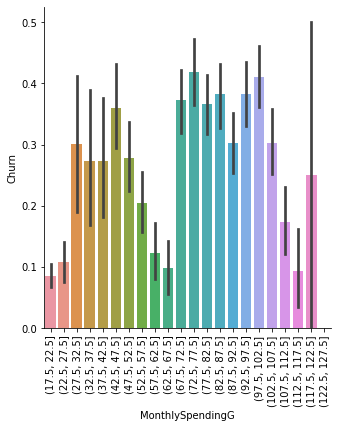

In [31]:
data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,130,5))
g = sns.catplot(x="MonthlySpendingG", y="Churn", data=data, kind="bar");
g.set_xticklabels(rotation=90);

In [49]:
def prepare_data(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
    data[num_cols] = data[num_cols].fillna(data[num_cols].mean())
    data[cat_cols] = data[cat_cols].fillna(data[num_cols].median()[0])
    data['ClientPeriodG'] = pd.qcut(data['ClientPeriod'], 13).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], 5).astype(str)
    data['TotalSpentG'] = pd.cut(data['TotalSpent'], 8).astype(str)
    # data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[0,10,42,100]).astype(str)
    # data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(-2.5,130,5)).astype(str)
    # data['ClientPeriodLog'] = np.log1p(data['ClientPeriod'])
    # data['MonthlySpendingLog'] = np.log1p(data['MonthlySpending'])
    # data['TotalSpentLog'] = np.log1p(data['TotalSpent'])
    # data['TotalSpentCox'] = stats.boxcox(data['TotalSpent'])[0]
    return data

def predict_data(model, test_data):
    submission = pd.read_csv('./submission.csv')
    submission['Churn'] = model.predict_proba(test_data)[:,1]
    submission.to_csv('./my_submission.csv', index=False)

test_data = pd.read_csv('./test.csv')
train_data = pd.read_csv('./train.csv')
test_data = prepare_data(test_data)
train_data = prepare_data(train_data)

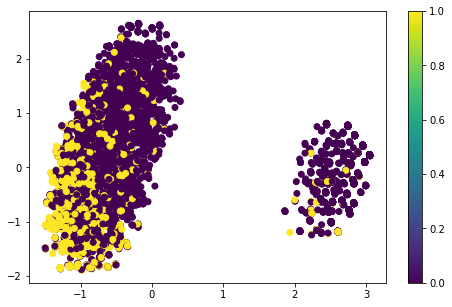

In [494]:
from sklearn.decomposition import PCA
data = pd.read_csv('./train.csv')
X, y = data[cat_cols], data[target_col]
X = pd.get_dummies(X, columns=cat_cols)
X2 = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(8,5))
plt.scatter(X2[:,0], X2[:,1], c=y)
plt.colorbar();

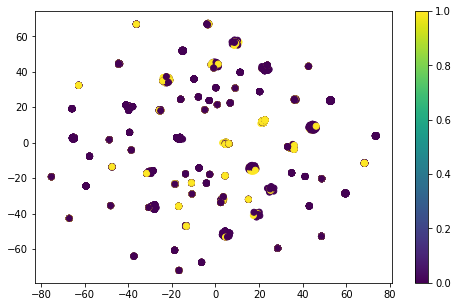

In [526]:
cols = ['HasTechSupportAccess','HasDeviceProtection','IsBillingPaperless','HasOnlineTV','PaymentMethod']

from sklearn.manifold import TSNE
data = pd.read_csv('./train.csv')
X, y = data[cols], data[target_col]
X = pd.get_dummies(X)
X2 = TSNE(n_components=2).fit_transform(X)
plt.figure(figsize=(8,5))
plt.scatter(X2[:,0], X2[:,1], c=y)
plt.colorbar();

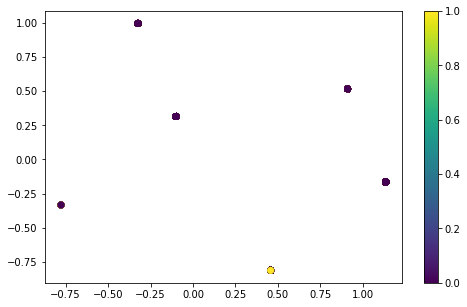

In [536]:
cols = ['HasTechSupportAccess','IsBillingPaperless']

from sklearn.decomposition import PCA
data = pd.read_csv('./train.csv')
X, y = data[cols], data[target_col]
X = pd.get_dummies(X)
X2 = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(8,5))
plt.scatter(X2[:,0], X2[:,1], c=y)
plt.colorbar();